# Here I perform multiple tests of the instrumental glitch waveform and of the code that goes along with it

In [1]:
import sys
sys.path.append("../") 

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import LISA as l

import Wavelet as wv
import Glitch as gl
import GlitchSlow as glsl
import MCMC_tools as mct

# constants
mHz = 1.0e-3
Hour = 3600.
Week = 24*7*Hour

In [7]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt

orb = l.Orbit(Tobs, dt=dt) # set up the LISA orbit
print("Nyquist Freq........ {} mHz".format(orb.f_ny*1000.))

A    = 2.0e-20
f0   = 5.0*mHz
tau  = .5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.0
Q = 2*np.pi*f0*tau

print("tau................. {} s".format(tau))
print("Q................... {}  ".format(Q))

comp_id = 0

paramsND = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0])
glitch = gl.Glitch(paramsND, orb, comp_id)

glitch.calc_TDI()
glitch.calc_snr()
glitch.adjust_snr(20) # Adjust the SNR to desired target
print("Glitch SNR.......... {}".format(glitch.SNR))
glitch.calc_Fish()

Nyquist Freq........ 33.333333333333336 mHz
tau................. 1800.0 s
Q................... 56.54866776461628  
Glitch SNR.......... 20.0


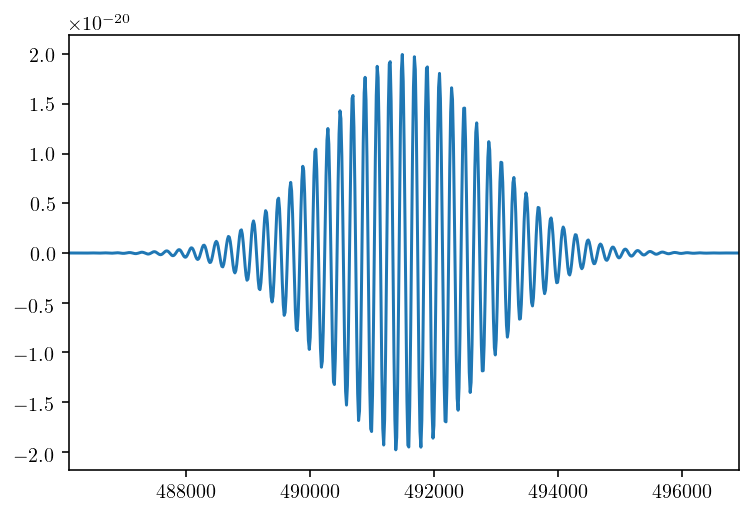

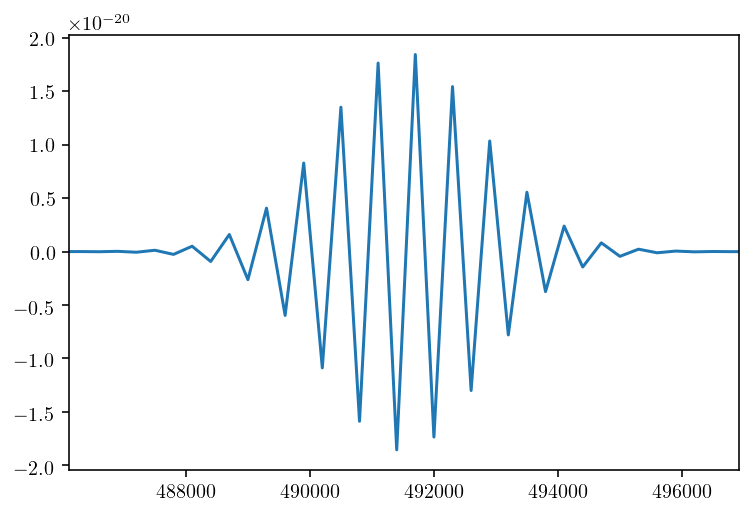

In [16]:
t = np.arange(0, orb.Tobs, orb.dt)
arg1 = 2.*np.pi*f0*(t - t0) + phi0
arg2 = (t - t0)/tau

psi = A*(np.cos(arg1) + 1.0j*np.sin(arg1))*np.exp(-arg2**2)
psi = psi.real

plt.plot(t, psi)
plt.xlim(t0 - 3*tau, t0 + 3*tau)
plt.show()

N = 6*orb.Tobs/tau
dt = orb.Tobs/N
t = np.arange(0, orb.Tobs, dt)
arg1 = 2.*np.pi*f0*(t - t0) + phi0
arg2 = (t - t0)/tau

psi = A*(np.cos(arg1) + 1.0j*np.sin(arg1))*np.exp(-arg2**2)
psi = psi.real

plt.plot(t, psi)
plt.xlim(t0 - 3*tau, t0 + 3*tau)
plt.show()

In [17]:
flag = 1

if (flag==1):
    print("Numeric Fisher Estimates")
    invFish = np.linalg.inv(glitch.Fisher)
    print("-------------------------------")
    print("A error............ {} %"      .format( 100*np.sqrt(invFish[0,0]) ))
    print("f0 error........... {} mHz"    .format(     np.sqrt(invFish[1,1]) ))
    print("t0 error........... {} minutes".format(     np.sqrt(invFish[2,2])*7*24*60 ))
    print("tau error.......... {} minutes".format(     np.sqrt(invFish[3,3])*7*24*60 ))
    print("phi0 error......... {}"        .format(     np.sqrt(invFish[4,4]) ))
    print()
    print("Analytic Fisher Estimates")
    print("-------------------------------")

    lnA_error = 1/glitch.SNR

    f0_error = 1/(np.pi*glitch.SNR*glitch.Wavelet.tau)

    t0_error = tau/glitch.SNR/np.sqrt(1 + (2*np.pi*f0*tau)**2)

    tau_error = 2*glitch.Wavelet.tau/np.sqrt(3.)/glitch.SNR

    phi0_error = 1/glitch.SNR

    print("A error............ {} %"  .format(100*lnA_error))
    print("f0 error........... {} mHz".format(f0_error/mHz))
    print("t0 error........... {} minutes".format(t0_error/60))
    print("tau error.......... {} minutes".format(tau_error/60))
    print("phi0 error......... {}".format(phi0_error))

Numeric Fisher Estimates
-------------------------------
A error............ 6.123971347374629 %
f0 error........... 0.002947441559993041 mHz
t0 error........... 4.500120052028803 minutes
tau error.......... 6.364297553781155 minutes
phi0 error......... 9.098717954534793

Analytic Fisher Estimates
-------------------------------
A error............ 5.000000000000001 %
f0 error........... 0.0029473137609610255 mHz
t0 error........... 0.026525363019117 minutes
tau error.......... 5.196152422706633 minutes
phi0 error......... 0.05000000000000001


In [23]:
Fish_Anal = np.zeros((5,5))
Fish_Anal[0,0] = 1
Fish_Anal[0,1] = tau*np.sqrt(np.pi/2)*np.exp(-2*(f0*np.pi*tau)**2)*mHz
Fish_Anal[0,3] = 1/(2*tau)*Week
Fish_Anal[1,1] = np.pi**2*(4*t0**2 + tau**2)*mHz**2
Fish_Anal[1,4] = 1/(2*np.pi*t0)*mHz
Fish_Anal[2,2] = 1/tau**2*Week**2
Fish_Anal[3,3] = 3/4/tau**2*Week**2
Fish_Anal[4,4] = 1

for i in range(5):
    for j in range(i+1,5):
        Fish_Anal[j][i] = Fish_Anal[i][j]
        
Fish_Anal *= glitch.SNR**2

# Plot Glitches

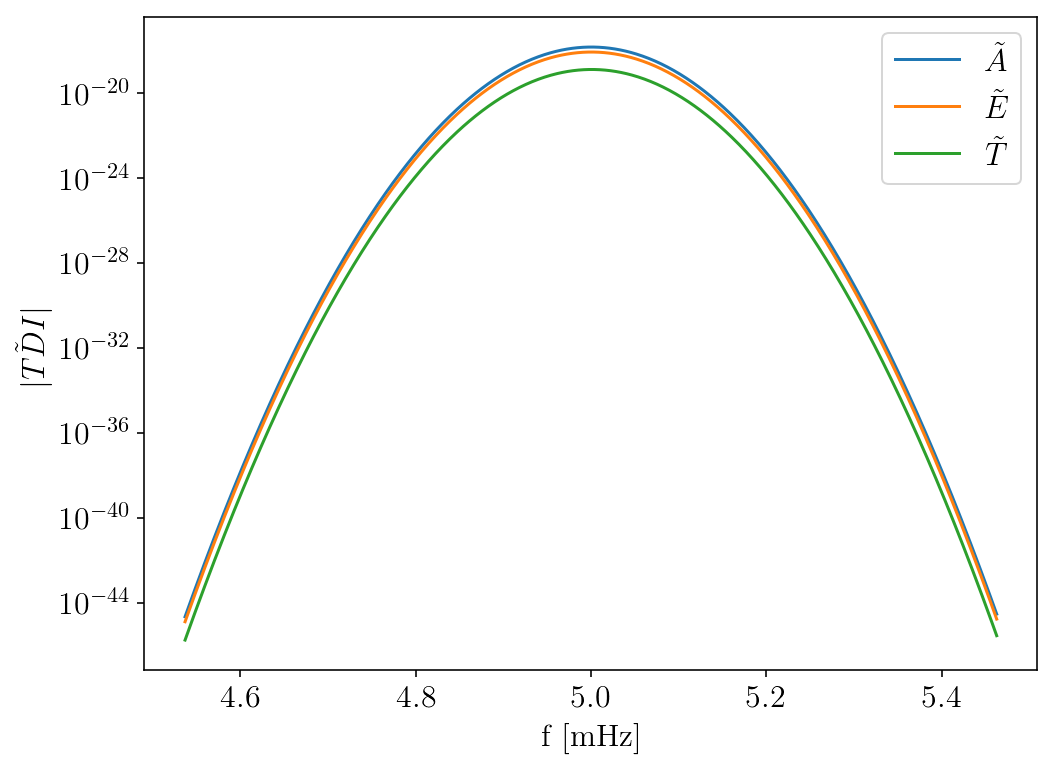

In [5]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r'f [mHz]', fontsize=16)
ax.set_ylabel(r'$|\tilde{TDI}|$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

f = glitch.TDI.freqs*1000

A = np.abs(glitch.TDI.A)
E = np.abs(glitch.TDI.E)
T = np.abs(glitch.TDI.T)

ax.semilogy(f, A, label=r'$\tilde{A}$')
ax.semilogy(f, E, label=r'$\tilde{E}$')
ax.semilogy(f, T, label=r'$\tilde{T}$')
    
ax.legend(loc='upper right', fontsize=16)
plt.show()

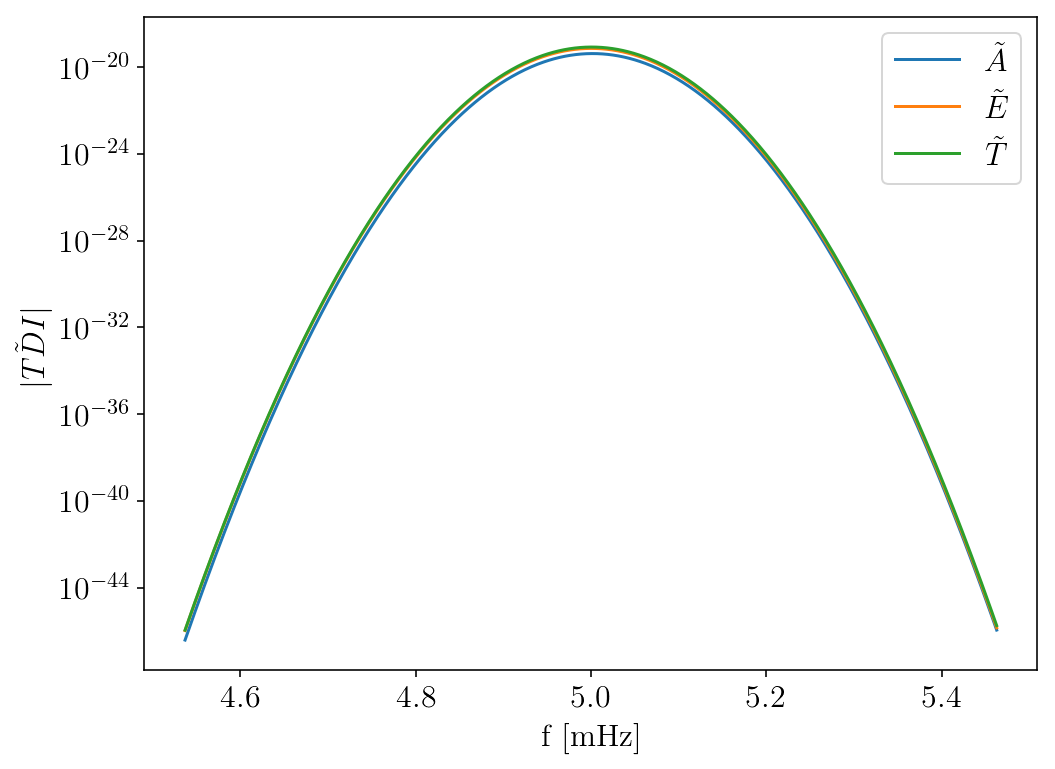

In [6]:
glitch_ACC = gl.Glitch(paramsND, orb, 7) 
glitch_ACC.calc_TDI()
glitch_ACC.calc_snr()
glitch_ACC.adjust_snr(10)

fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r'f [mHz]', fontsize=16)
ax.set_ylabel(r'$|\tilde{TDI}|$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

f = glitch_ACC.TDI.freqs*1000

A = np.abs(glitch_ACC.TDI.A)
E = np.abs(glitch_ACC.TDI.E)
T = np.abs(glitch_ACC.TDI.T)

ax.semilogy(f, A, label=r'$\tilde{A}$')
ax.semilogy(f, E, label=r'$\tilde{E}$')
ax.semilogy(f, T, label=r'$\tilde{T}$')
    
ax.legend(loc='upper right', fontsize=16)
plt.show()

# Plot the Glitch

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r'f [mHz]', fontsize=16)
ax.set_ylabel(r'$|\tilde{TDI}|$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlim(wave.f_min*1000, wave.f_max*1000)

mask = (glitch.TDI.freqs > wave.f_min) & (glitch.TDI.freqs < wave.f_max) 

f = glitch.TDI.freqs[mask]*1000

A = np.abs(glitch.TDI.A[mask])
E = np.abs(glitch.TDI.E[mask])
T = np.abs(glitch.TDI.T[mask])

y_vals = []

if (len(A[(A != 0.0)]) != 0):
    y_vals.append(A)
    ax.semilogy(f, A, label=r'$\tilde{A}$')

if (len(E[(E != 0.0)]) != 0):
    y_vals.append(np.abs(glitch.TDI.E[mask]))
    ax.semilogy(f, E, label=r'$\tilde{E}$')

if (len(T[(T != 0.0)]) != 0):
    y_vals.append(T)
    ax.semilogy(f, T, label=r'$\tilde{T}$')
    
y_min = 0.1*np.min(y_vals)
y_max = 10.*np.max(y_vals)

ax.set_ylim(y_min, y_max)
    
ax.legend(loc='upper right', fontsize=16)
plt.show()

# Look at signal in time domain

In [ ]:
X_time_dom = np.fft.irfft(glitch.TDI.X)

fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r't [weeks]', fontsize=16)
ax.set_ylabel(r'$X(t)$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.xlim((wave.t0 - 3.*wave.tau)/Week, (wave.t0 + 3.*wave.tau)/Week)
glitch.SNR**2
ax.plot(t[1:-1]/Week, X_time_dom, label=r'X')
ax.plot(wave.t/Week, wave.Psi.real, label=r'$\Psi$')

plt.legend(loc='upper left', fontsize=16)

plt.show()

# Create 3 Different Regimes (timescales) for Glitches Figure

T LISA laser........... 8.3391023799538 sec
0.002777777777777778
0.15589207816000003
1.199169832


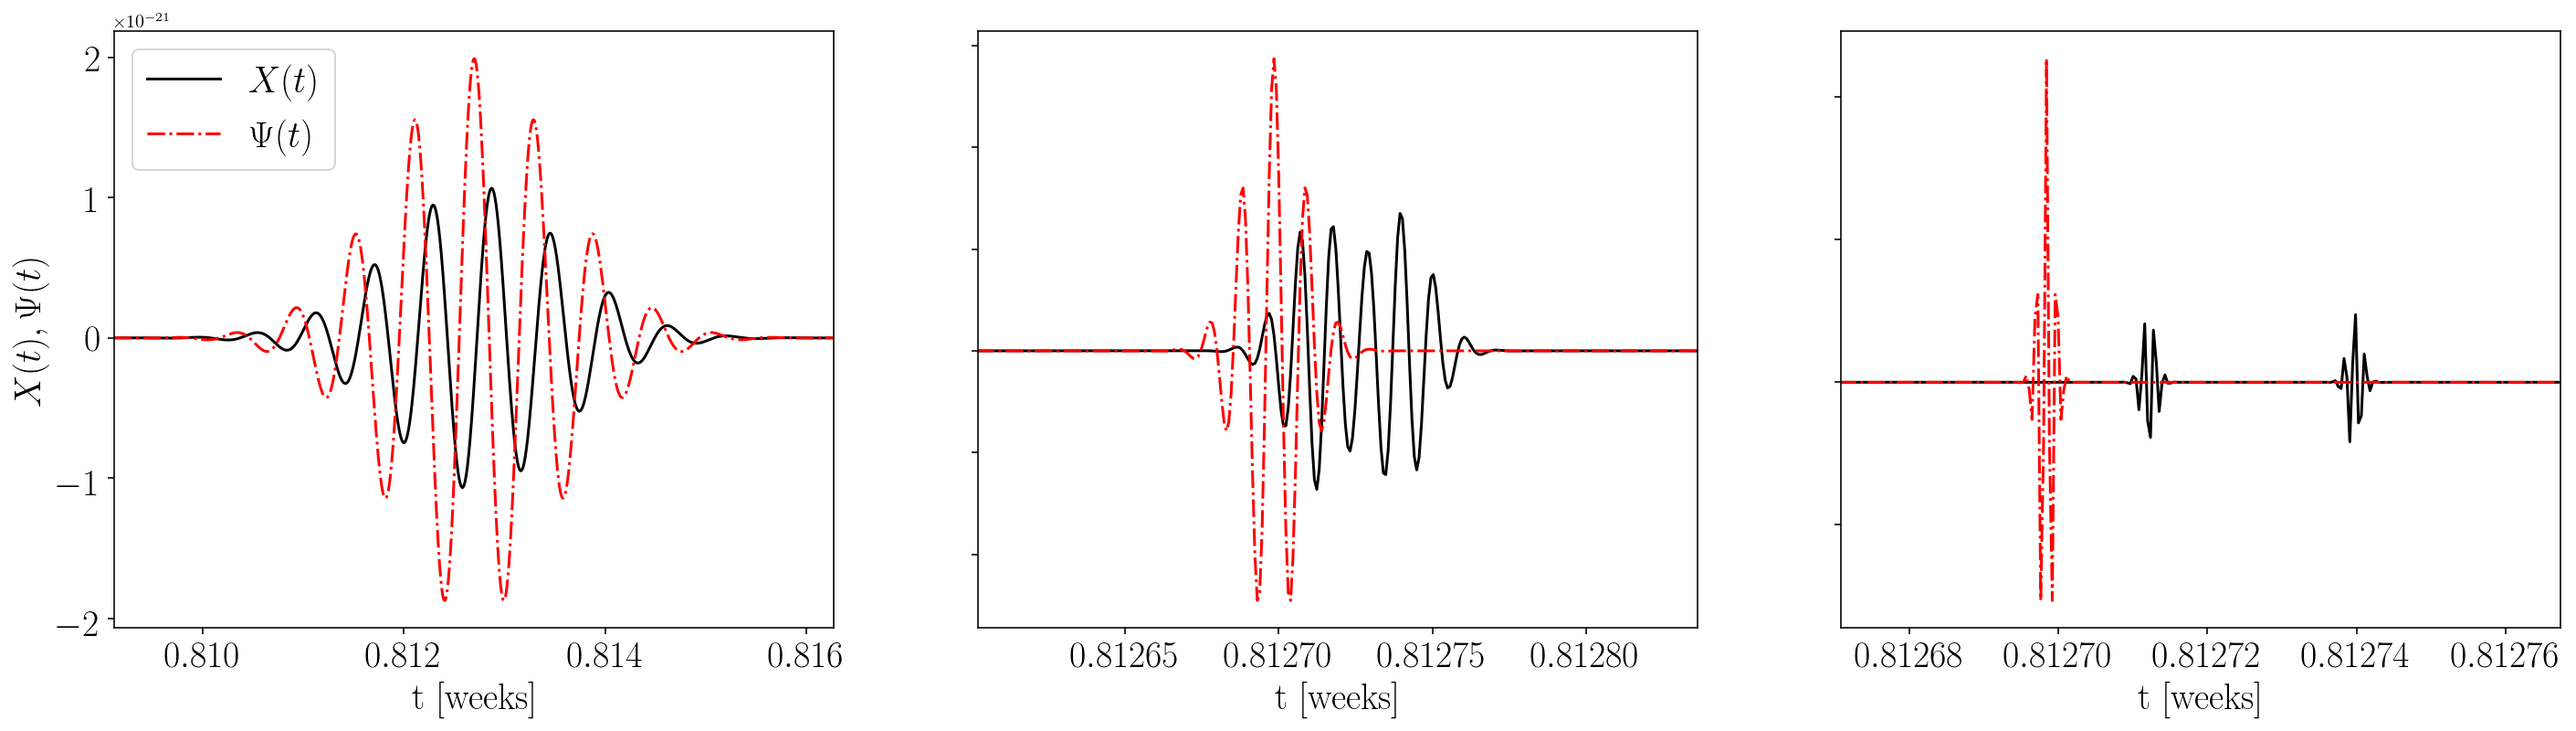

In [15]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt
orb = l.Orbit(Tobs, dt=dt)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit
h = np.zeros(len(t))

t_LISA = orb.L/l.Clight
print("T LISA laser........... {} sec".format(t_LISA))

#################### Create the first glitch ####################
# This is the LONG one
orb1 = l.Orbit(Tobs, dt=dt/8)
t1 = np.arange(0.0, orb1.Tobs, orb1.dt)
A    = 2.0e-20
tau  = 0.2*Hour
f0   = 2/tau
print(f0)
t0   = 0.5*orb.Tobs
phi0 = 0.0

wave1 = wv.Wavelet(A, f0, tau, t0, phi0, orb1)
wave1.calc_Psi()
wave1.make_padded_Psi(t1) 

glitch1 = glsl.Glitch(wave1, 0, orb1) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitch1.calc_TDI()
glitch1.calc_snr()
glitch1.adjust_snr(10)

#################### Create the second glitch ####################
# This is the COMPARABLE one
orb2 = l.Orbit(Tobs, dt=dt/32)
t2 = np.arange(0.0, orb2.Tobs, orb2.dt)
A    = 2.0e-20
tau  = t_LISA 
f0   = 1.3/tau
print(f0)
t0   = 0.5*orb.Tobs
phi0 = 0.0

wave2 = wv.Wavelet(A, f0, tau, t0, phi0, orb2)
wave2.calc_Psi()
wave2.make_padded_Psi(t2) 

glitch2 = glsl.Glitch(wave2, 0, orb2) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitch2.calc_TDI()
glitch2.calc_snr()
glitch2.adjust_snr(10)

#################### Create the third glitch ####################
# This is the SHORT one
orb3 = l.Orbit(Tobs, dt=dt/64)
t3 = np.arange(0.0, orb3.Tobs, orb3.dt)
A    = 2.0e-20
tau  = 0.1*t_LISA
f0   = 1/tau
print(f0)
t0   = 0.5*orb.Tobs
phi0 = 0.0

wave3 = wv.Wavelet(A, f0, tau, t0, phi0, orb3)
wave3.calc_Psi()
wave3.make_padded_Psi(t3) 

glitch3 = glsl.Glitch(wave3, 0, orb3) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitch3.calc_TDI()
glitch3.calc_snr()
glitch3.adjust_snr(10)

#################### Plot their time domain signal ####################

# Inverse FT the signal
X1 = np.fft.irfft(glitch1.TDI.X)*2
X2 = np.fft.irfft(glitch2.TDI.X)*2
X3 = np.fft.irfft(glitch3.TDI.X)*2

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*8,6))

ax[0].set_ylabel(r'$X(t), \Psi(t)$', fontsize=20)
ax[0].set_xlabel(r't [weeks]', fontsize=20)
ax[1].set_xlabel(r't [weeks]', fontsize=20)
ax[2].set_xlabel(r't [weeks]', fontsize=20)

# ax[1,0].set_ylabel(r'$\Psi(t)$', fontsize=16)
# ax[1,0].set_xlabel(r't [weeks]', fontsize=16)
# ax[1,1].set_xlabel(r't [weeks]', fontsize=16)
# ax[1,2].set_xlabel(r't [weeks]', fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

# ax[1,0].tick_params(axis='both', which='major', labelsize=16)
# ax[1,1].tick_params(axis='both', which='major', labelsize=16)
# ax[1,2].tick_params(axis='both', which='major', labelsize=16)
# ax[1,1].set_yticklabels([])
# ax[1,2].set_yticklabels([])

# plot the first glitch
ax[0].set_xlim((wave1.t0 - 3.*wave1.tau)/Week, (wave1.t0 + 3.*wave1.tau)/Week)
ax[0].plot(t1[1:-1]/Week, X1, color='k', label=r'$X(t)$')
ax[0].plot(t1/Week, wave1.Psi_padded.real, color='r', linestyle='-.', label=r'$\Psi(t)$')

# plot the second glitch
ax[1].set_xlim((wave2.t0 - 7.*wave2.tau)/Week, (wave2.t0 + 10.*wave2.tau)/Week)
ax[1].plot(t2[1:-1]/Week, X2, color='k')
ax[1].plot(t2/Week, wave2.Psi_padded.real, color='r', linestyle='-.')

# plot the third glitch
ax[2].set_xlim((wave3.t0 - 20.*wave3.tau)/Week, (wave3.t0 + 50.*wave3.tau)/Week)
ax[2].plot(t3[1:-1]/Week, X3, color='k')
ax[2].plot(t3/Week, wave3.Psi_padded.real, color='r', linestyle='-.')

ax[0].legend(loc='upper left', fontsize=20)
plt.savefig('../../../Figures/ThreeRegimes.pdf', bbox_inches="tight")
plt.show()

In [8]:
%timeit glitch3.calc_TDI()

1.84 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


T LISA laser........... 8.3391023799538 sec
0.002777777777777778
0.15589207816000003
1.199169832


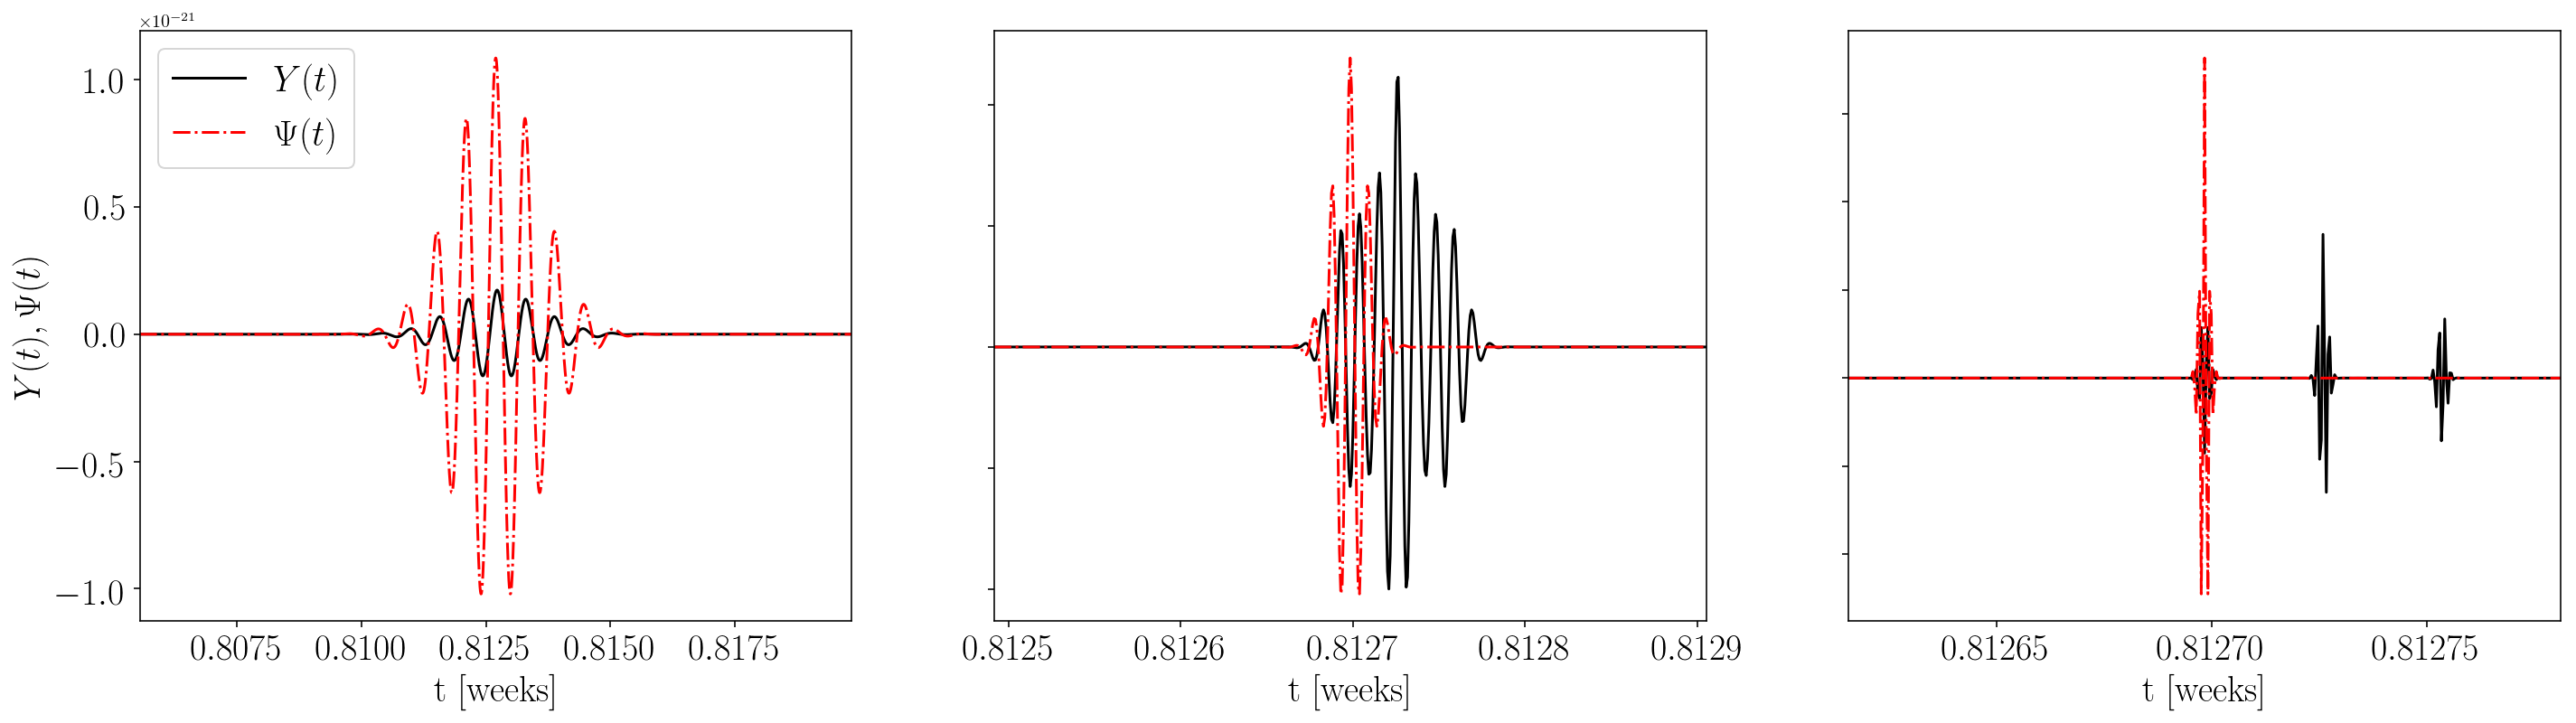

In [28]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt
orb = l.Orbit(Tobs, dt=dt)
t = np.arange(0.0, orb.Tobs, orb.dt) # set up the time of this orbit
h = np.zeros(len(t))

t_LISA = orb.L/l.Clight
print("T LISA laser........... {} sec".format(t_LISA))

#################### Create the first glitch ####################
# This is the LONG one
orb1 = l.Orbit(Tobs, dt=dt/8)
t1 = np.arange(0.0, orb1.Tobs, orb1.dt)
A    = 2.0e-20
tau  = 0.2*Hour
f0   = 2/tau
print(f0)
t0   = 0.5*orb.Tobs
phi0 = 0.0

wave1 = wv.Wavelet(A, f0, tau, t0, phi0, orb1)
wave1.calc_Psi()
wave1.make_padded_Psi(t1) 

glitch1 = glsl.Glitch(wave1, 6, orb1) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitch1.calc_TDI()
glitch1.calc_snr()
glitch1.adjust_snr(10)

#################### Create the second glitch ####################
# This is the COMPARABLE one
orb2 = l.Orbit(Tobs, dt=dt/32)
t2 = np.arange(0.0, orb2.Tobs, orb2.dt)
A    = 2.0e-20
tau  = t_LISA 
f0   = 1.3/tau
print(f0)
t0   = 0.5*orb.Tobs
phi0 = 0.0

wave2 = wv.Wavelet(A, f0, tau, t0, phi0, orb2)
wave2.calc_Psi()
wave2.make_padded_Psi(t2) 

glitch2 = glsl.Glitch(wave2, 6, orb2) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitch2.calc_TDI()
glitch2.calc_snr()
glitch2.adjust_snr(10)

#################### Create the third glitch ####################
# This is the SHORT one
orb3 = l.Orbit(Tobs, dt=dt/64)
t3 = np.arange(0.0, orb3.Tobs, orb3.dt)
A    = 2.0e-20
tau  = 0.1*t_LISA
f0   = 1/tau
print(f0)
t0   = 0.5*orb.Tobs
phi0 = 0.0

wave3 = wv.Wavelet(A, f0, tau, t0, phi0, orb3)
wave3.calc_Psi()
wave3.make_padded_Psi(t3) 

glitch3 = glsl.Glitch(wave3, 6, orb3) # 1: optical path glitch, pointing from S/C 1 to S/C 2
glitch3.calc_TDI()
glitch3.calc_snr()
glitch3.adjust_snr(10)

#################### Plot their time domain signal ####################

# Inverse FT the signal
X1 = np.fft.irfft(glitch1.TDI.Y)*2
X2 = np.fft.irfft(glitch2.TDI.Y)*2
X3 = np.fft.irfft(glitch3.TDI.Y)*2

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*8,6))

ax[0].set_ylabel(r'$Y(t), \Psi(t)$', fontsize=20)
ax[0].set_xlabel(r't [weeks]', fontsize=20)
ax[1].set_xlabel(r't [weeks]', fontsize=20)
ax[2].set_xlabel(r't [weeks]', fontsize=20)

# ax[1,0].set_ylabel(r'$\Psi(t)$', fontsize=16)
# ax[1,0].set_xlabel(r't [weeks]', fontsize=16)
# ax[1,1].set_xlabel(r't [weeks]', fontsize=16)
# ax[1,2].set_xlabel(r't [weeks]', fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

# ax[1,0].tick_params(axis='both', which='major', labelsize=16)
# ax[1,1].tick_params(axis='both', which='major', labelsize=16)
# ax[1,2].tick_params(axis='both', which='major', labelsize=16)
# ax[1,1].set_yticklabels([])
# ax[1,2].set_yticklabels([])


mult = 1
# plot the first glitch
ax[0].set_xlim((wave1.t0 - 6.*wave1.tau)/Week, (wave1.t0 + 6.*wave1.tau)/Week)
ax[0].plot(t1[1:-1]/Week, X1*mult, color='k', label=r'$Y(t)$')
ax[0].plot(t1/Week, wave1.Psi_padded.real, color='r', linestyle='-.', label=r'$\Psi(t)$')

# plot the second glitch
ax[1].set_xlim((wave2.t0 - 15.*wave2.tau)/Week, (wave2.t0 + 15.*wave2.tau)/Week)
ax[1].plot(t2[1:-1]/Week, X2*mult, color='k')
ax[1].plot(t2/Week, wave2.Psi_padded.real, color='r', linestyle='-.')

# plot the third glitch
ax[2].set_xlim((wave3.t0 - 60.*wave3.tau)/Week, (wave3.t0 + 60.*wave3.tau)/Week)
ax[2].plot(t3[1:-1]/Week, X3*mult, color='k')
ax[2].plot(t3/Week, wave3.Psi_padded.real, color='r', linestyle='-.')

ax[0].legend(loc='upper left', fontsize=20)
plt.savefig('../../../Figures/ThreeRegimesAccel.pdf', bbox_inches="tight")
plt.show()

In [29]:
4 + 0.7+1+0.5+0.7+0.7+1.0+1.0+1.0+0.5

11.100000000000001